In [41]:
import pandas as pd
import numpy as np
import gpflow
import matplotlib.pyplot as plt
import pickle

import utils as u
from models import Poisson_Model
%matplotlib inline


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
data = pd.read_csv('../data/gp_weekly_grid_parkslope.csv')
data['DATETIME'] = pd.to_datetime(data['DATETIME'])
e_s = (5.36 / data.GRID_SQUARE.max()) # 2016 mean weekly crashes in park slope
print(e_s)

0.111666666667


In [73]:
search_periods = [
                 [24,12],
                 [24,14],
                 [24,16],
                 [24,18]]



In [ ]:
import sys
with open('log_optimal_forecasting_period', 'w') as f:
    sys.stdout = f
    
for i, s in enumerate(search_periods):
    
    
    
    print('Beginning run {} : '.format(str(i)))
    #print('{} periods for training \n').format(s[0])
    #print('{} periods for testing \n').format(s[1])

    data_dict = u.preprocess(data, start_date= '2017/01/01', training_end_date= s[0], \
                                                           testing_end_date=s[1])

    m = Poisson_Model(data_dict['X_train'],data_dict['y_train'],use_priors=True, e_s= e_s, period = 52)
    m.compile()
    opt = gpflow.train.ScipyOptimizer()
    print(m.compute_log_likelihood())
    opt.minimize(m, maxiter = 500)
    
    u.pred_GP(m,data_dict)
    
    test = data_dict['test']

    gp = test.groupby('DATETIME')['gp_sq_error'].mean() #/ test.GRID_SQUARE.max()
    ar = u.run_AR(data_dict)
    summary = pd.concat([gp,ar],axis=1)
    summary.plot()

    print(summary.mean())


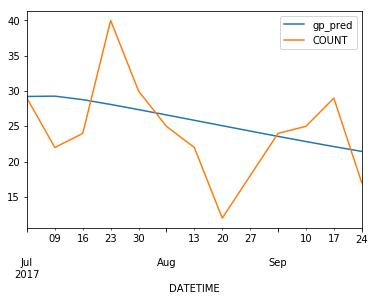

In [16]:
test.groupby('DATETIME')[['gp_pred','COUNT']].sum().plot()

In [19]:
test.groupby('GRID_SQUARE')['COUNT'].sum().sort_values(ascending = False).head()

GRID_SQUARE
33.0    44.0
44.0    20.0
21.0    19.0
35.0    18.0
27.0    16.0
Name: COUNT, dtype: float64

In [25]:
test[test.GRID_SQUARE == 33][['gp_pred','COUNT']]

,gp_pred,COUNT
DATETIME,,
2017-07-02,3.518106,3.0
2017-07-09,3.662330,3.0
2017-07-16,3.729008,3.0
2017-07-23,3.684784,5.0
2017-07-30,3.595103,8.0
2017-08-06,3.496820,4.0
2017-08-13,3.396871,3.0
2017-08-20,3.296573,3.0
2017-08-27,3.196773,2.0
